## 1. Pre-model Analysis: process and visualize data; get insights of features and target
## Problem Definition: translate the business needs into ml problems; design metrics to measure model performance
## Feature Engineering: create features which might improve model performance

# # 1.1 Import dataframe and check the data structure

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.max_row", 500)
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Kaggle_COVID19_version6_9-5-20.csv")

In [3]:
df.shape

(628730, 25)

In [4]:
print('\033[1m'+'Missing value percentage:'+'\033[0m')
percent_missing=df.isnull().sum() * 100 / len(df)
round(percent_missing, 2)

Missing value percentage:


age                                         76.39
age_band                                    76.33
background_diseases                         92.87
background_diseases_binary                  17.28
city                                        44.20
confirmed_date                               0.56
country                                      0.16
date_onset_symptoms                         79.20
deceased_date                               99.15
infected_by                                 99.74
infection_place                             98.19
region                                      22.09
released_date                               99.22
return_date                                 99.62
severity_illness                            96.46
sex                                         75.56
smoking                                     81.43
symptoms                                    99.74
treatment                                   79.13
id                                           0.00


# 1.2 There are 25 coloums and ~630k rows in the dataframe, and most of them have too many missing values.

In [5]:
df = df[df.country == 'mexico']

In [6]:
df.shape

(119323, 25)

In [7]:
print('\033[1m'+'Missing value percentage for mexico:'+'\033[0m')
percent_missing=df.isnull().sum() * 100 / len(df)
round(percent_missing, 2)

Missing value percentage for mexico:


age                                           0.00
age_band                                      0.00
background_diseases                          62.61
background_diseases_binary                   60.84
city                                         99.55
confirmed_date                                0.05
country                                       0.00
date_onset_symptoms                           0.01
deceased_date                                96.19
infected_by                                 100.00
infection_place                              99.43
region                                       98.23
released_date                               100.00
return_date                                  99.44
severity_illness                             94.63
sex                                           0.02
smoking                                       2.18
symptoms                                    100.00
treatment                                     1.77
id                             

## 1.3 Among the area features city, region and country, only country will be kept. Since there are too many missing values, and we guess that is due to the origin of the data. We found that mexico has the fewest missing values among all countries. So only data from mexico will be used.

## 1.4 There are only two catelogues deceased and critical for severity_illness in the mexico dataset, so the miss values might be catelogues not in these two. In the following, we will define death+critical as high_risk and the missing values as low_risk.

In [8]:
df.severity_illness.value_counts(dropna=False)

NaN         112914
deceased      3849
critical      2560
Name: severity_illness, dtype: int64

In [9]:
df.severity_illness.unique()

array([nan, 'deceased', 'critical'], dtype=object)

In [10]:
len(df[df['deceased_date'].notnull()])

4545

In [11]:
len(df[df['deceased_date'].notnull() & (df['severity_illness'].notnull())])

4545

In [12]:
len(df[df['deceased_date'].notnull() & (df['severity_illness'] != 'deceased')])

696

In [13]:
len(df[df['deceased_date'].notnull() & (df['severity_illness'] != 'critical')])

3849

In [14]:
"""
Generate transformer to generate feature high_risk - 1 ('critical' and 'deceased') and 0 (else)
"""

df['severity_illness'] = df.severity_illness.apply(lambda x: 1 if str(x)!='nan' else 0)

In [15]:
df = df.rename(columns={'severity_illness': 'high_risk'})

In [16]:
df.high_risk.value_counts(dropna=False)

0    112914
1      6409
Name: high_risk, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119323 entries, 35393 to 331327
Data columns (total 25 columns):
age                                         119321 non-null float64
age_band                                    119321 non-null float64
background_diseases                         44615 non-null object
background_diseases_binary                  46727 non-null float64
city                                        542 non-null object
confirmed_date                              119263 non-null object
country                                     119323 non-null object
date_onset_symptoms                         119317 non-null object
deceased_date                               4545 non-null object
infected_by                                 0 non-null object
infection_place                             678 non-null object
region                                      2108 non-null object
released_date                               0 non-null object
return_date                      

# 1.5 All colomns, except severity_illness, with >90% missing values will be dropped. The colomn treatment is not informatic, and will be dropped.

In [18]:
df.treatment.value_counts(dropna=False)

clinic          86437
hospitalized    30774
NaN              2112
Name: treatment, dtype: int64

In [19]:
df = df[['confirmed_date', 'date_onset_symptoms', 'high_risk', 'age', 'age_band', 'sex', 'country', 
         'background_diseases', 'background_diseases_binary', 'smoking',  
         'date_onset_symptoms_until_confirmed_date']].reset_index(drop=True)
df = df.rename(columns={'date_onset_symptoms_until_confirmed_date': 'days_apart'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119323 entries, 0 to 119322
Data columns (total 11 columns):
confirmed_date                119263 non-null object
date_onset_symptoms           119317 non-null object
high_risk                     119323 non-null int64
age                           119321 non-null float64
age_band                      119321 non-null float64
sex                           119299 non-null object
country                       119323 non-null object
background_diseases           44615 non-null object
background_diseases_binary    46727 non-null float64
smoking                       116726 non-null float64
days_apart                    119257 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 10.0+ MB


# 1.6 Column days_apart is confirmed_date subtract date_onset_symptoms, so only confirmed_date will be kept. Almost all non-null background_diseases_binary records are positive, so the null values should be positive and will be fixed before split the train-test

In [20]:
df = df.drop(['date_onset_symptoms'],axis = 1).reset_index(drop=True)
df['background_diseases_binary']=df.background_diseases_binary.apply(
    lambda x: 0.0 if str(x)=='nan' else x).reset_index(drop=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119323 entries, 0 to 119322
Data columns (total 10 columns):
confirmed_date                119263 non-null object
high_risk                     119323 non-null int64
age                           119321 non-null float64
age_band                      119321 non-null float64
sex                           119299 non-null object
country                       119323 non-null object
background_diseases           44615 non-null object
background_diseases_binary    119323 non-null float64
smoking                       116726 non-null float64
days_apart                    119257 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.1+ MB


# 1.7 The distributions of age and age_band are similar, so only age will be kept.

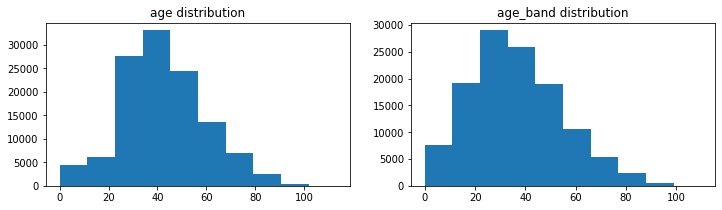

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(df.age)
ax1.set_title('age distribution')
ax2.hist(df.age_band)
ax2.set_title('age_band distribution')
plt.show()

In [23]:
df = df.drop(['age_band'],axis = 1).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119323 entries, 0 to 119322
Data columns (total 9 columns):
confirmed_date                119263 non-null object
high_risk                     119323 non-null int64
age                           119321 non-null float64
sex                           119299 non-null object
country                       119323 non-null object
background_diseases           44615 non-null object
background_diseases_binary    119323 non-null float64
smoking                       116726 non-null float64
days_apart                    119257 non-null float64
dtypes: float64(4), int64(1), object(4)
memory usage: 8.2+ MB


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

back_dis = df['background_diseases'].fillna('unknown_disease')
vectorizer = CountVectorizer()
vectorizer.fit(back_dis)
back_dis= vectorizer.transform(back_dis)
df_back_dis= pd.DataFrame(back_dis.todense())
df_back_dis.columns = vectorizer.get_feature_names()
df_back_dis.head()

df_back_dis.shape

(119323, 9)

In [25]:
df = pd.concat([df.reset_index(drop=True),
                 df_back_dis.reset_index(drop=True)], axis=1).drop(['background_diseases'],axis = 1)

# 2. Modeling: Model selection, feature elimination, validation, hyperparameter tuning

# 2.1 The data will be split into two groups randomly: one for model training and the other for model testing.

In [26]:
df = df.drop(['confirmed_date', 'country'],axis = 1).reset_index(drop=True)
df_shuffled = df.sample(n=len(df), random_state=30)

train_raw = df_shuffled.iloc[: (len(df) - len(df)//4), :].reset_index(drop=True)
test_raw = df_shuffled.iloc[(len(df) - len(df)//4) :, :].reset_index(drop=True)

# 2.2 Transform the missing values.

In [27]:
train_raw['age'] = train_raw.age.apply(lambda x: train_raw.age.mean() if str(x)=='nan' else x).reset_index(drop=True)
test_raw['age'] = test_raw.age.map(lambda x: train_raw.age.mean() if str(x)=='nan' else x).reset_index(drop=True)

train_raw['sex']=train_raw.sex.map({'male': 0,'female': 1}).reset_index(drop=True)
test_raw['sex']=test_raw.sex.map({'male': 0,'female': 1}).reset_index(drop=True)

train_raw['smoking']=train_raw.smoking.apply(lambda x: 0.0 if str(x)=='nan' else x).reset_index(drop=True)
test_raw['smoking']=test_raw.smoking.apply(lambda x: 0.0 if str(x)=='nan' else x).reset_index(drop=True)

train_raw['days_apart'] = train_raw.days_apart.map(lambda x: train_raw.days_apart.mean() if str(x)=='nan' else x
                                    ).reset_index(drop=True)
test_raw['days_apart'] = test_raw.days_apart.map(lambda x: train_raw.days_apart.mean() if str(x)=='nan' else x
                                  ).reset_index(drop=True)

In [28]:
train_raw = train_raw[train_raw.sex.notnull()].reset_index(drop=True)
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89473 entries, 0 to 89472
Data columns (total 15 columns):
high_risk                     89473 non-null int64
age                           89473 non-null float64
sex                           89473 non-null float64
background_diseases_binary    89473 non-null float64
smoking                       89473 non-null float64
days_apart                    89473 non-null float64
asthma                        89473 non-null int64
cardiovascular                89473 non-null int64
diabetes                      89473 non-null int64
failure                       89473 non-null int64
hypertension                  89473 non-null int64
immunosuppression             89473 non-null int64
kidney                        89473 non-null int64
obesity                       89473 non-null int64
unknown_disease               89473 non-null int64
dtypes: float64(5), int64(10)
memory usage: 10.2 MB


In [29]:
test_raw = test_raw[test_raw.sex.notnull()].reset_index(drop=True)
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29826 entries, 0 to 29825
Data columns (total 15 columns):
high_risk                     29826 non-null int64
age                           29826 non-null float64
sex                           29826 non-null float64
background_diseases_binary    29826 non-null float64
smoking                       29826 non-null float64
days_apart                    29826 non-null float64
asthma                        29826 non-null int64
cardiovascular                29826 non-null int64
diabetes                      29826 non-null int64
failure                       29826 non-null int64
hypertension                  29826 non-null int64
immunosuppression             29826 non-null int64
kidney                        29826 non-null int64
obesity                       29826 non-null int64
unknown_disease               29826 non-null int64
dtypes: float64(5), int64(10)
memory usage: 3.4 MB


# 2.3 Define target and features

In [30]:
features = list(train_raw.columns)
target = 'high_risk'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]
X_test = test_raw[features]
y_test = test_raw[target]

# 2.4 The two classes in the target are very imbalanced, so resampling is needed.

In [31]:
train_raw.high_risk.value_counts(normalize=True)

0    0.946364
1    0.053636
Name: high_risk, dtype: float64

In [32]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
import numpy as np

over = SMOTE(random_state = 2, sampling_strategy=0.1, k_neighbors=4) 
X_train_res1, y_train_res1 = over.fit_sample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy=0.5)
X_train_res, y_train_res = under.fit_sample(X_train_res1, y_train_res1)

Using TensorFlow backend.


# 2.5 Establish models.

## 2.5.1 Logistic regression classifier

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.pipeline import Pipeline

steps = [('rescale', MinMaxScaler()),
         ('logr', LogisticRegression())]
model_logr = Pipeline(steps)
model_logr = model_logr.fit(X_train_res, y_train_res)

y_train_proba_logr = model_logr.predict_proba(X_train_res)
y_test_proba_logr = model_logr.predict_proba(X_test)

### 2.5.2 Naive Bayes Classifier

In [34]:
from sklearn.naive_bayes import GaussianNB

model_nb= GaussianNB()
model_nb.fit(X_train_res, y_train_res)

y_train_proba_nb = model_nb.predict_proba(X_train_res)
y_test_proba_nb = model_nb.predict_proba(X_test)

#### 2.5.3 Nearest Neighbor Classifier

In [35]:
from sklearn.neighbors import KNeighborsClassifier

model_knc= KNeighborsClassifier()
model_knc.fit(X_train_res, y_train_res)

y_train_proba_knc = model_knc.predict_proba(X_train_res)
y_test_proba_knc = model_knc.predict_proba(X_test)

### 2.5.4 Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_res, y_train_res)

y_train_proba_dt = model_dt.predict_proba(X_train_res)
y_test_proba_dt = model_dt.predict_proba(X_test)

### 2.5.5 Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_res, y_train_res)

y_train_proba_rf = model_rf.predict_proba(X_train_res)
y_test_proba_rf = model_rf.predict_proba(X_test)

### 2.5.6 Gradient Boosting Classifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_res, y_train_res)

y_train_proba_gb = model_gb.predict_proba(X_train_res)
y_test_proba_gb = model_gb.predict_proba(X_test)

### 2.5.7 XGBoost Classifier

In [39]:
import xgboost as xgb
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train_res, y_train_res)

y_train_proba_xgb = model_xgb.predict_proba(X_train_res)
y_test_proba_xgb = model_xgb.predict_proba(X_test)

### 2.6 Compare ROC-AUC scores from different models.

In [40]:
from sklearn.metrics import roc_auc_score

print(f"model_logr roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_logr[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_logr[:, 1]):.4f}")

print(f"model_nb roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_nb[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_nb[:, 1]):.4f}")

print(f"model_knc roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_knc[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_knc[:, 1]):.4f}")

print(f"model_dt roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_dt[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_dt[:, 1]):.4f}")

print(f"model_rf roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_rf[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_rf[:, 1]):.4f}")

print(f"model_gb roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_gb[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_gb[:, 1]):.4f}")

print(f"model_xgb roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_xgb[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_xgb[:, 1]):.4f}")

model_logr roc_auc| Train: 0.7774| Test:  0.7769
model_nb roc_auc| Train: 0.7499| Test:  0.7574
model_knc roc_auc| Train: 0.8967| Test:  0.7193
model_dt roc_auc| Train: 0.9782| Test:  0.6186
model_rf roc_auc| Train: 0.9708| Test:  0.7359
model_gb roc_auc| Train: 0.8496| Test:  0.8073
model_xgb roc_auc| Train: 0.8481| Test:  0.8071


### 2.7 XGBoost model seems to be the best, try to tune the hyperparameters for it.

In [41]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 50, 100, 200],
        'reg_lambda': [0.01, 1, 100],
        'max_depth': [3, 4, 5]
        }

random_search = RandomizedSearchCV(model_xgb, param_distributions=params, scoring='roc_auc')

random_search.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        

In [42]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [43]:
printmd('**Best hyperparameters:**')
print(random_search.best_params_)

**Best hyperparameters:**

{'subsample': 1.0, 'reg_lambda': 0.01, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 0.6}


In [44]:
import xgboost as xgb
from xgboost import XGBClassifier

model_xgb = XGBClassifier(subsample=1.0, reg_lambda=1, n_Estimators=100, colsample_bytree=1.0, gamma=2, 
                          max_depth=4, min_child_weight=1)
model_xgb.fit(X_train_res, y_train_res)

y_train_proba_xgb = model_xgb.predict_proba(X_train_res)
y_test_proba_xgb = model_xgb.predict_proba(X_test)

In [45]:
print(f"model_xgb roc_auc| Train: {roc_auc_score(y_train_res, y_train_proba_xgb[:, 1]):.4f}"
      f"| Test:  {roc_auc_score(y_test, y_test_proba_xgb[:, 1]):.4f}")

model_xgb roc_auc| Train: 0.8567| Test:  0.8060


In [46]:
from sklearn.metrics import classification_report
y_train_pred_xgb = model_xgb.predict(X_train_res)
y_test_pred_xgb = model_xgb.predict(X_test)

printmd('**model_xgb Train Classification Report:**')
print(classification_report(y_train_res, y_train_pred_xgb))

printmd('**model_xgb Test Classification Report:**')
print(classification_report(y_test, y_test_pred_xgb))

**model_xgb Train Classification Report:**

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     16934
           1       0.69      0.63      0.66      8467

    accuracy                           0.78     25401
   macro avg       0.76      0.75      0.75     25401
weighted avg       0.78      0.78      0.78     25401



**model_xgb Test Classification Report:**

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     28216
           1       0.18      0.54      0.27      1610

    accuracy                           0.84     29826
   macro avg       0.57      0.70      0.59     29826
weighted avg       0.93      0.84      0.87     29826



In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_xgb)
cm

array([[24148,  4068],
       [  739,   871]])

### 2.8 Feature importance

In [48]:
importances_xgb = model_xgb.feature_importances_
importances_xgb

array([0.18659906, 0.16919635, 0.19688436, 0.1336109 , 0.05826733,
       0.07820808, 0.01531216, 0.07602688, 0.02803234, 0.01559616,
       0.01845843, 0.        , 0.02380795, 0.        ], dtype=float32)

[('kidney', 0.0),
 ('unknown_disease', 0.0),
 ('cardiovascular', 0.015312162),
 ('hypertension', 0.015596163),
 ('immunosuppression', 0.018458433),
 ('obesity', 0.023807952),
 ('failure', 0.028032342),
 ('days_apart', 0.058267325),
 ('diabetes', 0.07602688),
 ('asthma', 0.07820808),
 ('smoking', 0.1336109),
 ('sex', 0.16919635),
 ('age', 0.18659906),
 ('background_diseases_binary', 0.19688436)]

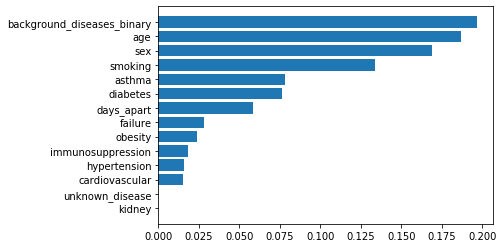

In [49]:
res = sorted(zip(features, importances_xgb), key=lambda x: x[1])
d = dict(res)

plt.barh(range(len(importances_xgb)), d.values())
plt.yticks(range(len(importances_xgb)), d.keys())
res

In [50]:
high_risk_train = train_raw[y_train == 1]
low_risk_train = train_raw[y_train == 0]

high_risk_test = test_raw[y_test == 1]
low_risk_test = test_raw[y_test == 0]

**Distribution on background_diseases_binary: 0=No, 1=Yes**

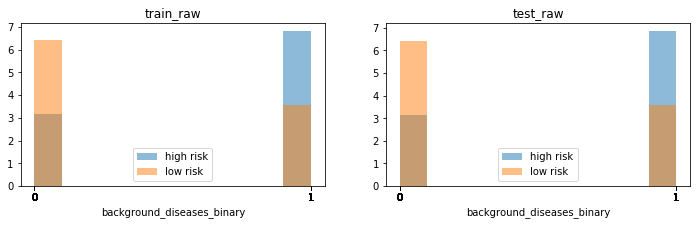

In [51]:
printmd('**Distribution on background_diseases_binary: 0=No, 1=Yes**')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(high_risk_train['background_diseases_binary'], alpha=0.5, density=True, label='high risk')
ax1.hist(low_risk_train['background_diseases_binary'], alpha=0.5, density=True, label='low risk')
ax1.set_title('train_raw')
ax2.hist(high_risk_test['background_diseases_binary'], alpha=0.5, density=True, label='high risk')
ax2.hist(low_risk_test['background_diseases_binary'], alpha=0.5, density=True, label='low risk')
ax2.set_title('test_raw')
ax1.legend(loc="upper mid")
ax2.legend(loc="upper mid")
ax2.set_xlabel('background_diseases_binary')
ax1.set_xlabel('background_diseases_binary')
ax1.set_xticks(high_risk_train['background_diseases_binary'].values)
ax2.set_xticks(high_risk_train['background_diseases_binary'].values)
plt.show()

**Distribution on sex: 0=male, 1=female**

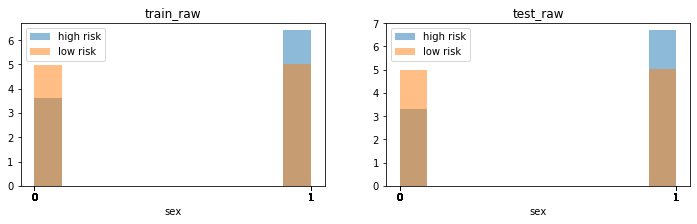

In [52]:
printmd('**Distribution on sex: 0=male, 1=female**')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(high_risk_train['sex'], alpha=0.5, density=True, label='high risk')
ax1.hist(low_risk_train['sex'], alpha=0.5, density=True, label='low risk')
ax1.set_title('train_raw')
ax2.hist(high_risk_test['sex'], alpha=0.5, density=True, label='high risk')
ax2.hist(low_risk_test['sex'], alpha=0.5, density=True, label='low risk')
ax2.set_title('test_raw')
ax1.legend(loc="upper mid")
ax2.legend(loc="upper mid")
ax2.set_xlabel('sex')
ax1.set_xlabel('sex')
ax1.set_xticks(high_risk_train['sex'].values)
ax2.set_xticks(high_risk_train['sex'].values)
plt.show()

**Distribution on age**

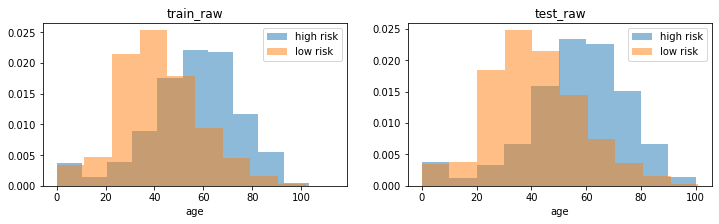

In [53]:
printmd('**Distribution on age**')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(high_risk_train['age'], alpha=0.5, density=True, label='high risk')
ax1.hist(low_risk_train['age'], alpha=0.5, density=True, label='low risk')
ax1.set_title('train_raw')
ax2.hist(high_risk_test['age'], alpha=0.5, density=True, label='high risk')
ax2.hist(low_risk_test['age'], alpha=0.5, density=True, label='low risk')
ax2.set_title('test_raw')
ax1.legend(loc="upper mid")
ax2.legend(loc="upper mid")
ax2.set_xlabel('age')
ax1.set_xlabel('age')
plt.show()

**Distribution on smoking: 0=No, 1=Yes**

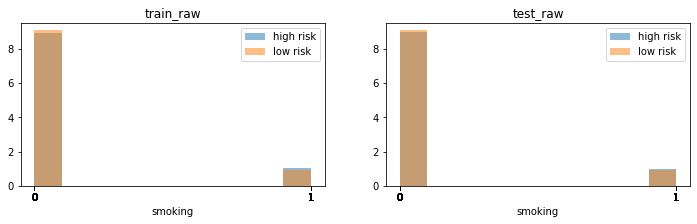

In [54]:
printmd('**Distribution on smoking: 0=No, 1=Yes**')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(high_risk_train['smoking'], alpha=0.5, density=True, label='high risk')
ax1.hist(low_risk_train['smoking'], alpha=0.5, density=True, label='low risk')
ax1.set_title('train_raw')
ax2.hist(high_risk_test['smoking'], alpha=0.5, density=True, label='high risk')
ax2.hist(low_risk_test['smoking'], alpha=0.5, density=True, label='low risk')
ax2.set_title('test_raw')
ax1.legend(loc="upper mid")
ax2.legend(loc="upper mid")
ax2.set_xlabel('smoking')
ax1.set_xlabel('smoking')
ax1.set_xticks(high_risk_train['smoking'].values)
ax2.set_xticks(high_risk_train['smoking'].values)
plt.show()

In [55]:
female_train = train_raw[X_train['sex'] == 1]
male_train = train_raw[X_train['sex'] == 0]

female_test = test_raw[X_test['sex'] == 1]
male_test = test_raw[X_test['sex'] == 0]

**Gender distribution on age**

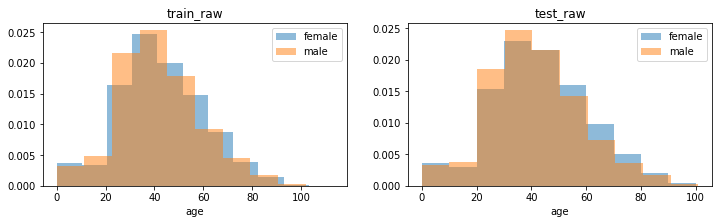

In [56]:
printmd('**Gender distribution on age**')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.hist(female_train['age'], alpha=0.5, density=True, label='female')
ax1.hist(male_train['age'], alpha=0.5, density=True, label='male')
ax1.set_title('train_raw')
ax2.hist(female_test['age'], alpha=0.5, density=True, label='female')
ax2.hist(male_test['age'], alpha=0.5, density=True, label='male')
ax2.set_title('test_raw')
ax1.legend(loc="upper mid")
ax2.legend(loc="upper mid")
ax2.set_xlabel('age')
ax1.set_xlabel('age')
plt.show()

### 3. After modeling analyzing

1. Aged people, especially those who have background diseases should be more cautious about COVID-19.
2. Unexpectedly but interestingly, people who have asthma seem to be less risky to the virus. Can the medicines for asthma do something?